In [3]:
%pip install polars
%pip install tabulate
%pip install --upgrade pip
%pip install scikit-learn
%pip install mlxtend
%pip install seaborn


In [4]:

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from tabulate import tabulate

In [8]:
# import csv

# with open('games.csv', 'r') as f:
#     dialect = csv.Sniffer().sniff(f.read(1024))
#     f.seek(0)
#     # print all properties and values of the dialect object
# with open('games.csv', 'r') as f:
#     dialect = csv.Sniffer().sniff(f.read(1024))
#     f.seek(0)
#     # print all properties and values of the dialect object


#     print(dir(dialect))
#     print(dir(dialect))



In [5]:
import pandas as pd
import json
import polars as pl


# Read the CSV file with appropriate parameters
def parse_games_csv(file_path):
    # Use the csv engine with appropriate quoting parameters
    # We need to handle nested quotes in the JSON price field
    df = pd.read_csv(
        file_path,
        quotechar='"',  # Double quotes are used to quote fields
        doublequote=True,  # Double quotes are escaped by doubling them
        escapechar='\\',  # Backslash can be used to escape quotes
        na_values=['\\N', 'N'],  # Null values are represented as \N
    )

    # Clean up the price_overview column and convert it to a more usable format
    def parse_price(price_str):
        if pd.isna(price_str):
            return None
        try:
            # Replace escaped quotes
            price_str = price_str.replace('\\"', '"')
            return json.loads(price_str)
        except (json.JSONDecodeError, AttributeError):
            return None

    # Apply the function to parse price_overview
    if 'price_overview' in df.columns:
        df['price_overview_parsed'] = df['price_overview'].apply(parse_price)

        # Extract useful price information into separate columns
        df['currency'] = df['price_overview_parsed'].apply(lambda x: x.get('currency') if x else None)
        df['price'] = df['price_overview_parsed'].apply(lambda x: float(x.get('final')) / 100 if x else None)
        df['original_price'] = df['price_overview_parsed'].apply(lambda x: x.get('initial') if x else None)
        df['discount_percent'] = df['price_overview_parsed'].apply(lambda x: x.get('discount_percent') if x else 0)
        df['final_price'] = df['price_overview_parsed'].apply(lambda x: x.get('final_formatted').replace(",", ".") if x else None)

    # Convert release_date to datetime
    if 'release_date' in df.columns:
        df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

    # Convert is_free to boolean
    if 'is_free' in df.columns:
        df['is_free'] = df['is_free'].astype('Int64').fillna(-1)
        df['is_free'] = df['is_free'] == 1

    return df


# Example usage
games_df = parse_games_csv('/content/games.csv')
games_df.head()

,app_id,name,release_date,is_free,price_overview,languages,type,price_overview_parsed,currency,price,original_price,discount_percent,final_price
0,10,Counter-Strike,2000-11-01,False,"{""final"": 819, ""initial"": 819, ""currency"": ""EU...","English<strong>*</strong>, French<strong>*</st...",game,"{'final': 819, 'initial': 819, 'currency': 'EU...",EUR,8.19,819.0,0,8.19€
1,20,Team Fortress Classic,1999-04-01,False,"{""final"": 499, ""initial"": 499, ""currency"": ""EU...","English, French, German, Italian, Spanish - Sp...",game,"{'final': 499, 'initial': 499, 'currency': 'EU...",EUR,4.99,499.0,0,4.99€
2,30,Day of Defeat,2003-05-01,False,"{""final"": 499, ""initial"": 499, ""currency"": ""EU...","English, French, German, Italian, Spanish - Spain",game,"{'final': 499, 'initial': 499, 'currency': 'EU...",EUR,4.99,499.0,0,4.99€
3,40,Deathmatch Classic,2001-06-01,False,"{""final"": 499, ""initial"": 499, ""currency"": ""EU...","English, French, German, Italian, Spanish - Sp...",game,"{'final': 499, 'initial': 499, 'currency': 'EU...",EUR,4.99,499.0,0,4.99€
4,50,Half-Life: Opposing Force,1999-11-01,False,"{""final"": 499, ""initial"": 499, ""currency"": ""EU...","English, French, German, Korean",game,"{'final': 499, 'initial': 499, 'currency': 'EU...",EUR,4.99,499.0,0,4.99€


In [6]:
clean_games_df = games_df.drop(columns=['price_overview', 'price_overview_parsed'])

# clean_games_df['final_price'] = clean_games_df['final_price'].astype(float)

# drop rows with missing values
clean_games_df = clean_games_df.dropna()
clean_games_df['languages'] = clean_games_df['languages'].apply(lambda x: x.replace("<strong>*</strong>", "").replace("<br>", ", ").split(", "))
# tabulate(clean_games_df.head(), tablefmt='pipe', headers='keys')
clean_games_df.head()


,app_id,name,release_date,is_free,languages,type,currency,price,original_price,discount_percent,final_price
0,10,Counter-Strike,2000-11-01,False,"[English, French, German, Italian, Spanish - S...",game,EUR,8.19,819.0,0,8.19€
1,20,Team Fortress Classic,1999-04-01,False,"[English, French, German, Italian, Spanish - S...",game,EUR,4.99,499.0,0,4.99€
2,30,Day of Defeat,2003-05-01,False,"[English, French, German, Italian, Spanish - S...",game,EUR,4.99,499.0,0,4.99€
3,40,Deathmatch Classic,2001-06-01,False,"[English, French, German, Italian, Spanish - S...",game,EUR,4.99,499.0,0,4.99€
4,50,Half-Life: Opposing Force,1999-11-01,False,"[English, French, German, Korean]",game,EUR,4.99,499.0,0,4.99€


In [7]:
# Load datasets
tags = pd.read_csv('/content/tags.csv')
# games = pd.read_csv('games.csv')
# reviews = pd.read_csv('reviews.csv')
genre = pd.read_csv('/content/genres.csv')

In [8]:
reviews = df = pd.read_csv(
        "/content/reviews.csv",
        quotechar='"',  # Double quotes are used to quote fields
        doublequote=True,  # Double quotes are escaped by doubling them
        escapechar='\\',  # Backslash can be used to escape quotes
        na_values=['\\N', 'N'],  # Null values are represented as \N
    )

reviews = reviews.drop(columns=['reviews'])
reviews.head()

,app_id,review_score,review_score_description,positive,negative,total,metacritic_score,recommendations,steamspy_user_score,steamspy_score_rank,steamspy_positive,steamspy_negative
0,10,9.0,Overwhelmingly Positive,235403.0,6207.0,241610.0,88.0,153259.0,0.0,NaN,235397.0,6207.0
1,20,8.0,Very Positive,7315.0,1094.0,8409.0,NaN,6268.0,0.0,NaN,7314.0,1092.0
2,30,8.0,Very Positive,6249.0,672.0,6921.0,79.0,4146.0,0.0,NaN,6246.0,672.0
3,40,8.0,Very Positive,2542.0,524.0,3066.0,NaN,2218.0,0.0,NaN,2541.0,525.0
4,50,9.0,Overwhelmingly Positive,22263.0,1111.0,23374.0,NaN,20144.0,0.0,NaN,22260.0,1112.0


In [9]:
grouped_tags = tags.groupby('app_id')['tag'].apply(list).reset_index()

exploded_tags = grouped_tags.explode('tag')

# Create binary features for each tag
tag_dummies = pd.get_dummies(exploded_tags['tag'], prefix='tag')

# Combine the binary features with the app_id
tag_dummies = pd.concat([exploded_tags['app_id'], tag_dummies], axis=1)

# Group by app_id and aggregate the binary features
tag_dummies = tag_dummies.groupby('app_id').max().reset_index()

tag_dummies.head()

,app_id,tag_1980s,tag_1990's,tag_2.5D,tag_2D,tag_2D Fighter,tag_2D Platformer,tag_360 Video,tag_3D,tag_3D Fighter,...,tag_Well-Written,tag_Werewolves,tag_Western,tag_Wholesome,tag_Word Game,tag_World War I,tag_World War II,tag_Wrestling,tag_Zombies,tag_eSports
0,10,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,20,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,30,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,40,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,50,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
# Merge binary tags with the main dataset
data = pd.merge(clean_games_df, tag_dummies, on='app_id', how='left')
data = pd.merge(data, reviews, on='app_id', how='left')
data = pd.merge(data, genre, on='app_id', how='left')

# Drop rows with missing values in key columns
data = data.dropna(subset=['price', 'review_score'])
data.head()

,app_id,name,release_date,is_free,languages,type,currency,price,original_price,discount_percent,...,positive,negative,total,metacritic_score,recommendations,steamspy_user_score,steamspy_score_rank,steamspy_positive,steamspy_negative,genre
0,10,Counter-Strike,2000-11-01,False,"[English, French, German, Italian, Spanish - S...",game,EUR,8.19,819.0,0,...,235403.0,6207.0,241610.0,88.0,153259.0,0.0,NaN,235397.0,6207.0,Action
1,20,Team Fortress Classic,1999-04-01,False,"[English, French, German, Italian, Spanish - S...",game,EUR,4.99,499.0,0,...,7315.0,1094.0,8409.0,NaN,6268.0,0.0,NaN,7314.0,1092.0,Action
2,30,Day of Defeat,2003-05-01,False,"[English, French, German, Italian, Spanish - S...",game,EUR,4.99,499.0,0,...,6249.0,672.0,6921.0,79.0,4146.0,0.0,NaN,6246.0,672.0,Action
3,40,Deathmatch Classic,2001-06-01,False,"[English, French, German, Italian, Spanish - S...",game,EUR,4.99,499.0,0,...,2542.0,524.0,3066.0,NaN,2218.0,0.0,NaN,2541.0,525.0,Action
4,50,Half-Life: Opposing Force,1999-11-01,False,"[English, French, German, Korean]",game,EUR,4.99,499.0,0,...,22263.0,1111.0,23374.0,NaN,20144.0,0.0,NaN,22260.0,1112.0,Action


In [11]:
features = ['price', 'review_score'] + list(tag_dummies.columns[1:])
X = data[features]

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [12]:
new_data = data.copy()
columns_to_dropna = ['price', 'review_score'] + list(tag_dummies.columns[1:])
new_data = new_data.dropna(subset=columns_to_dropna)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207935 entries, 0 to 210609
Columns: 470 entries, app_id to genre
dtypes: boolean(1), datetime64[ns](1), float64(12), int64(2), object(454)
memory usage: 746.0+ MB


In [13]:
Y = X.dropna()
Y.head()

,price,review_score,tag_1980s,tag_1990's,tag_2.5D,tag_2D,tag_2D Fighter,tag_2D Platformer,tag_360 Video,tag_3D,...,tag_Well-Written,tag_Werewolves,tag_Western,tag_Wholesome,tag_Word Game,tag_World War I,tag_World War II,tag_Wrestling,tag_Zombies,tag_eSports
0,8.19,9.0,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,4.99,8.0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,4.99,8.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,4.99,8.0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4.99,9.0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Y)

In [15]:
inertia = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(range(1, 12), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title("Elbow method for optimal k")
plt.show()


KeyboardInterrupt: 

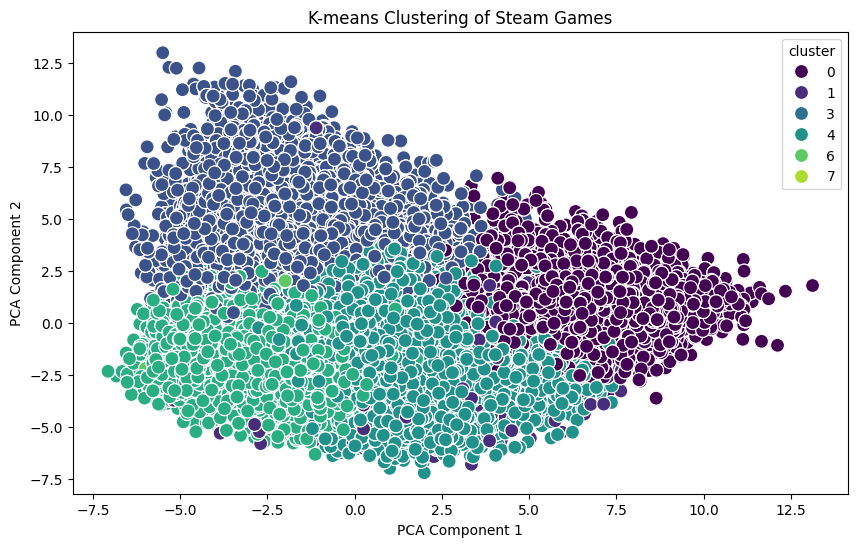

In [16]:
# Apply K-means with optimal K
kmeans = KMeans(n_clusters=9, random_state=42)

# make a new dataframe to store kmeans predictions


new_data['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
new_data['pca_1'] = X_pca[:, 0]
new_data['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', data=new_data, palette='viridis', s=100)
plt.title('K-means Clustering of Steam Games')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [21]:
print("hello")

hello


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
Z = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Game Index')
plt.ylabel('Distance')
plt.show()